In [1]:
import wandb
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor

import pyqg_explorer.systems.regression_systems as reg_sys
import pyqg_explorer.models.fcnn as fcnn
import pyqg_explorer.util.performance as performance
import pyqg_explorer.dataset.forcing_dataset as forcing_dataset

/home/cp3759/Projects/pyqg_experiments/pyqg_subgrid_experiments/__init__.py:19: UserWarning: Unable to load differentiable_parameterizations, install autograd if you want to use these
  warnings.warn("Unable to load differentiable_parameterizations, install autograd if you want to use these")


In [2]:
config=reg_sys.config
config["subsample"]=500
config["epochs"]=4

In [3]:
emulator_dataset=forcing_dataset.OfflineDataset("/scratch/cp3759/pyqg_data/sims/0_step/all.nc",seed=config["seed"],subsample=config["subsample"],drop_spin_up=config["drop_spin_up"])

## Need to save renormalisation factors for when the CNN is plugged into pyqg
config["q_mean_upper"]=emulator_dataset.q_mean_upper
config["q_mean_lower"]=emulator_dataset.q_mean_lower
config["q_std_upper"]=emulator_dataset.q_std_upper
config["q_std_lower"]=emulator_dataset.q_std_lower
config["s_mean_upper"]=emulator_dataset.s_mean_upper
config["s_mean_lower"]=emulator_dataset.s_mean_lower
config["s_std_upper"]=emulator_dataset.s_std_upper
config["s_std_lower"]=emulator_dataset.s_std_lower

In [4]:
train_loader = DataLoader(
    emulator_dataset,
    num_workers=10,
    batch_size=config["batch_size"],
    sampler=SubsetRandomSampler(emulator_dataset.train_idx),
)
valid_loader = DataLoader(
    emulator_dataset,
    num_workers=10,
    batch_size=config["batch_size"],
    sampler=SubsetRandomSampler(emulator_dataset.valid_idx),
)

/ext3/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
## Define CNN module
model=fcnn.FCNN(config)

In [6]:
## Loss function defined in a RegressionSystem module
system=reg_sys.RegressionSystem(model,config)

In [7]:
wandb.init(project="joint_opt_dev", entity="m2lines",config=config)
## Add number of parameters of model to config
wandb.config["theta learnable parameters"]=sum(p.numel() for p in model.parameters())
wandb.watch(model, log_freq=1)

logger = WandbLogger()
## This will log learning rate to wandb
lr_monitor=LearningRateMonitor(logging_interval='epoch')

trainer = pl.Trainer(
    accelerator="auto", ## Use GPU if lightning can find one
    max_epochs=config["epochs"],
    logger=logger,
    enable_progress_bar=False,
    callbacks=[lr_monitor]
    )

trainer.fit(system, train_loader, valid_loader)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chris-pedersen (m2lines). Use `wandb login --relogin` to force relogin


/ext3/miniconda3/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | network   | FCNN    | 268 K 
--------------------------------------
268 K     Trainable params
0         Non-trainable params
268 K     Total params
1.073     Total estimated model params size (MB)
/ext3/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in cur

INFO:  Logger initialized
INFO: Step: 1000, Time: 3.60e+06, KE: 4.02e-07, CFL: 0.006
INFO: Step: 2000, Time: 7.20e+06, KE: 4.26e-07, CFL: 0.006
INFO: Step: 3000, Time: 1.08e+07, KE: 7.65e-07, CFL: 0.006
INFO: Step: 4000, Time: 1.44e+07, KE: 1.41e-06, CFL: 0.006
INFO: Step: 5000, Time: 1.80e+07, KE: 2.50e-06, CFL: 0.006
INFO: Step: 6000, Time: 2.16e+07, KE: 4.09e-06, CFL: 0.007
INFO: Step: 7000, Time: 2.52e+07, KE: 6.39e-06, CFL: 0.007
INFO: Step: 8000, Time: 2.88e+07, KE: 9.85e-06, CFL: 0.008
INFO: Step: 9000, Time: 3.24e+07, KE: 1.48e-05, CFL: 0.009
INFO: Step: 10000, Time: 3.60e+07, KE: 2.10e-05, CFL: 0.009
INFO: Step: 11000, Time: 3.96e+07, KE: 2.91e-05, CFL: 0.010
INFO: Step: 12000, Time: 4.32e+07, KE: 4.08e-05, CFL: 0.013
INFO: Step: 13000, Time: 4.68e+07, KE: 5.81e-05, CFL: 0.015
INFO: Step: 14000, Time: 5.04e+07, KE: 8.33e-05, CFL: 0.017
INFO: Step: 15000, Time: 5.40e+07, KE: 1.16e-04, CFL: 0.025
INFO: Step: 16000, Time: 5.76e+07, KE: 1.57e-04, CFL: 0.029
INFO: Step: 17000, Time

epoch,▁▁▃▃▆▆██
lr-AdamW,▁▁▁▁
train_loss,█▂▁▁
trainer/global_step,▁▃▃▃▄▄▅▆▆▆██
valid_loss,█▄▂▁
epoch,3
lr-AdamW,0.001
train_loss,0.15983
trainer/global_step,763
valid_loss,0.15603


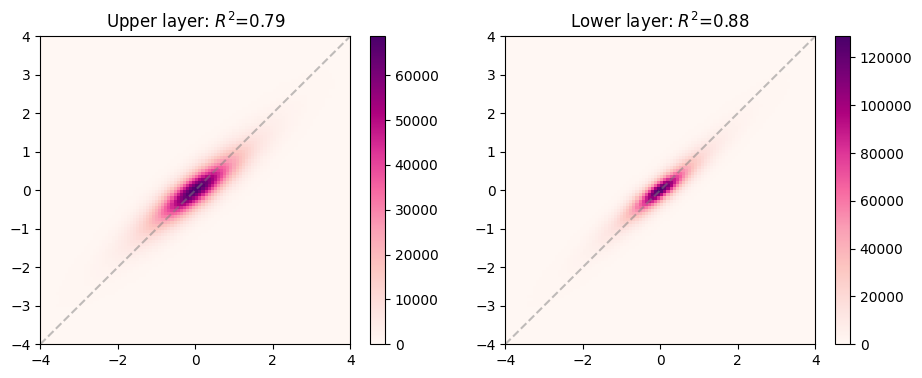

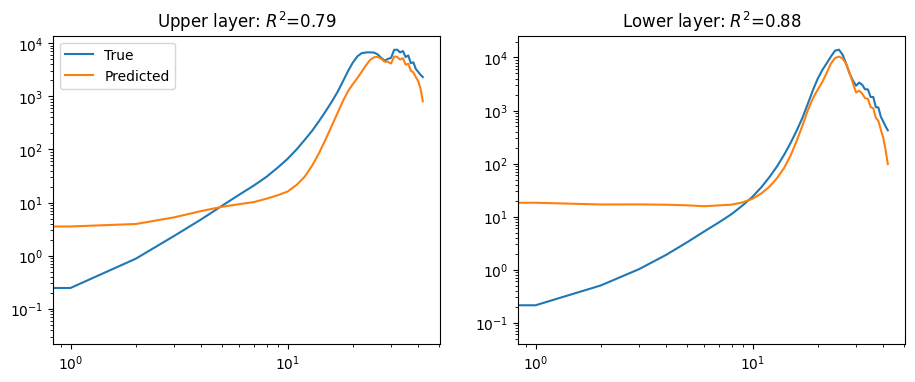

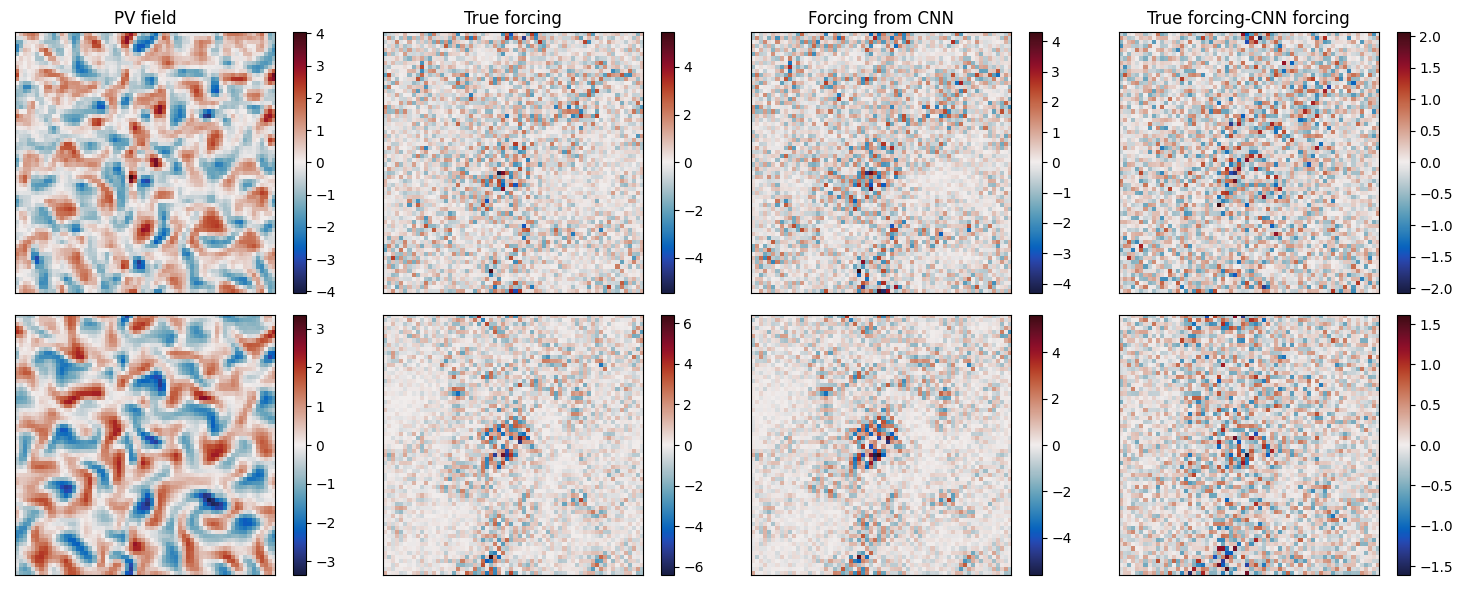

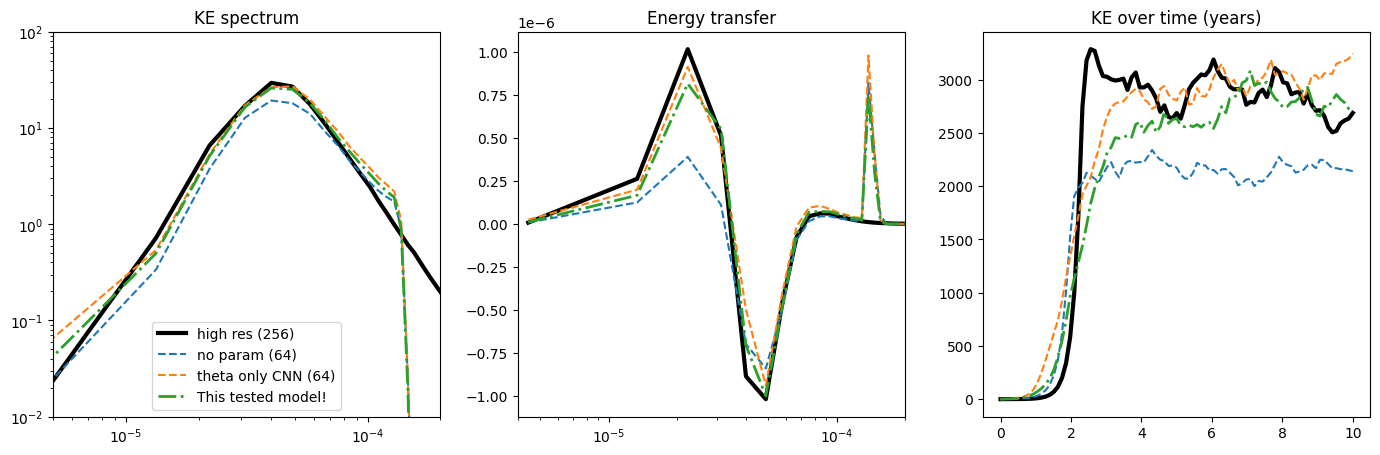

In [8]:
## Run performance tests, and upload figures to wandb
perf=performance.ParameterizationPerformance(model,valid_loader,threshold=5000)

dist_fig=perf.get_distribution_2d()
figure_dist=wandb.Image(dist_fig)
wandb.log({"Distributions": figure_dist})

power_fig=perf.get_power_spectrum()
figure_power=wandb.Image(power_fig)
wandb.log({"Power spectra": figure_power})

field_fig=perf.get_fields()
figure_field=wandb.Image(field_fig)
wandb.log({"Random fields": figure_field})

online_fig=perf.online_comparison()
figure_online=wandb.Image(online_fig)
wandb.log({"Online test": figure_online})

wandb.finish()